In [174]:
%run ./ipy_setup.py

In [217]:
#!/usr/bin/env python

# imports
import os, sys, getopt
import pysam
from itertools import groupby
from operator import itemgetter
import pandas as pd
import numpy as np

global count
count = 0

# init main
def main(argv):
    hairs_file = ''
    hapcut_file = ''
    bam_file = ''
    out_file = ''
    help = 'greedy_partitioner.py -h <input.hairs> -c <input.hapcut> -i <input.bam> -o <output.ann.bam>'
    try:
        opts, args = getopt.getopt(argv,"h:c:i:o:",["hairs=","hapcut=", "input=", "output="])
    except getopt.GetoptError:
        print help
        sys.exit(2)
    for opt, arg in opts:
        if opt == '--help':
            print help
            sys.exit()
        elif opt in ("-h", "--hairs"):
            hairs_file = arg
        elif opt in ("-c", "--hapcut"):
            hapcut_file = arg
        elif opt in ("-i", "--input"):
            bam_file = arg
        elif opt in ("-o", "--output"):
            out_file = arg
        else:
            assert False, "unhandled option"

    assert pysam.Samfile(bam_file, 'rb'), 'ERROR: Cannot open bam file for reading.'
    assert open(bam_file + '.bai', 'rb'), 'ERROR: bam file is not indexed!'
    bam_fp = pysam.Samfile(bam_file, 'rb')

    if out_file==None:
        out_file = bam_file + ".ann_haplotypes_" + time.strftime("%m%d%y_%H%M%S") + '.bam'

    assert pysam.AlignmentFile(out_file, "wb", template=bam_fp), 'ERROR: Cannot open output file for writing.'
    out_fp = pysam.AlignmentFile(out_file, "wb", template=bam_fp)

    assert open(hairs_file), 'ERROR: Cannot access hairs file.'
    assert open(hapcut_file), 'ERROR: Cannot open hapcut file.'

    hair_reader = HairReader(hairs_file)
    block_reader = HapCutReader(hapcut_file)
    stats_file = out_file + ".interblock_stats.tsv"
    sys.stdout.write("Loaded greedy_partitoner.py, beginning execution. \n")
    sys.stdout.write("Placing hairfile reads into haplotype blocks. \n")
    sys.stdout.flush()
    hair_reader.assemble_blocks(block_reader)
    sys.stdout.write("Placing bamfile reads into haplotype blocks. \n")
    sys.stdout.flush()
    unphased_reads = unphased_heuristics(hair_reader, block_reader, bam_fp)
    sys.stdout.write("Partitioning reads. \n")
    sys.stdout.flush()
    tag_reads(bam_fp, hair_reader, block_reader, unphased_reads, out_fp) #begin tagging reads
    sys.stdout.write("Calculating interblock statistics. \n")
    sys.stdout.flush()
    interblock_stats(hair_reader, block_reader, stats_file, bam_fp) #generate interblock stats
    bam_fp.close()
    out_fp.close()

# end of main

### CLASSES ###

class BlockVariant:
    def __init__ (self, variantline):
        # variant_id haplotype_1 haplotype_2 chromosome position refallele variantallele genotype allele_counts:genotype_likelihoods:delta:MEC_variant
        ll = variantline.strip().split("\t")
        var_id, hap1, hap2, chrom, pos, r_allele, v_allele, genotype, info_str = ll
        self.chrom, self.r_allele, self.v_allele, self.info_str = chrom, r_allele, v_allele, info_str
        self.var_id, self.hap1, self.hap2, self.pos = int(var_id), hap1, hap2, int(pos)
        allele_counts, genotype_likelihoods, delta, MEC_variant = info_str.split(":")[0:4]
        self.ref_count, self.alt_count = map(int, allele_counts.split(","))
        gen_00, gen_01, gen_11 = map(float, genotype_likelihoods.split(","))
        self.gen_like = {"0/0":gen_00, "0/1":gen_01, "1/1":gen_11}
        self.delta = float(delta)
        self.MEC_variant = MEC_variant
    def __repr__ (self):
        return "<BlockVariant, var_id: %s>" % str(self.var_id)


class Block: # part of block reader
    def __init__ (self, blockline):
        # "BLOCK: offset:" first_variant_block "len:" length_of_block "phased": phased_variants_block SPAN: 
        # lengthspanned MECscore score fragments #fragments

        ll               = blockline.strip().split()
        self.offset      = int(ll[2])
        self.total_len   = int(ll[4])
        self.phased      = int(ll[6])
        self.span        = int(ll[8])
        self.MECscore    = float(ll[10])
        self.fragments   = int(ll[12])
        self.variants 	 = dict() # default to empty
        self.variant_ids = set()
        self.chrom = 0
        self.start = 0
        self.end = 0
        self.informative_reads = []
        self.unphased_reads = []
        self.unphased_read_set = set()
        self.read_count = 0
        self.read_set = set()

    def __repr__ (self):
        return "<Block, offset_id: %s>" % str(self.offset)

    def addVariant(self, variantline):
        variant = BlockVariant(variantline)
        self.variants[variant.var_id] = variant
        self.variant_ids.add(variant.var_id)
        self.updatePosition()

    def updatePosition(self): # we need to do this because sometimes the variant isn't associated with a block
        positions = []
        chrom = None
        for k,variant in self.variants.iteritems():
            if chrom == None:
                chrom = variant.chrom
            positions.append(variant.pos)
        self.chrom = chrom
        self.start = np.min(positions)
        self.end = np.max(positions)

    def addReadsToBlock(self, read_dict):
        self.informative_reads = []
        for k,read in read_dict.iteritems():
            read_ids = frozenset([var[0] for block in read.blocks for var in block])
            if len(set(read_ids).intersection(set(self.variant_ids))) > 0:
                self.informative_reads.append(read)
        self.read_count = len(self.informative_reads)
        self.read_set = frozenset([x.read_id for x in self.informative_reads])

    def concordance(self, input_reads):
        ''' this should return a dict of (#T,#F) tuples per variant
         each element is a variant's concordance with the reads
         using the read's haplotype information, we can establish whether the read's phasing
         is consistent with how the variant was phased '''
        variant_concord = dict()
        support_reads_hap2 = 0
        against_reads_hap2 = 0
        support_reads_hap1 = 0
        against_reads_hap1 = 0
        for k,variant in self.variants.iteritems():
            for read in input_reads:
                if variant.var_id in read.positions:
                    read_allele = read.alleles[read.positions.index(variant.var_id)]
                    hapstate = read.haplotypes[self.offset]
                    if hapstate == 2:
                        if variant.hap2 != read_allele:
                            against_reads_hap2 += 1
                        else:
                            support_reads_hap2 += 1
                    else:
                        if variant.hap1 != read_allele:
                            against_reads_hap1 += 1
                        else:
                            support_reads_hap1 += 1
        variant_concord[self.offset] = {"hap1": (support_reads_hap1, against_reads_hap1), 
                                               "hap2": (support_reads_hap2, against_reads_hap2)}
        return variant_concord

    def variant(self, var_id):
        try:
            return self.variants[var_id]
        except:
            return None

    def interblock_reads(self, input_reads):
        out_reads = []
        for read in input_reads:
            if read.read_id not in self.read_set:
                if read.chrom == self.chrom:
                    if ((read.start < self.end) & (read.end > self.end)) | \
                        ((read.end > self.start) & (read.start < self.start)) | \
                        ((read.end <= self.end) & (read.start >= self.start)):
                        out_reads.append(read)
        return out_reads
    
    def add_read(self, read_obj):
        if read_obj.read_id not in self.read_set:
            self.informative_reads.append(read_obj)
            self.read_set.add(read_obj.read_id)
    
    def add_unphased_reads(self, bam_fp):
        reads = bam_fp.fetch(region=self.chrom + ':' + str(self.start) + '-' + str(self.end))
        for read in reads:
            if read.query_name not in self.read_set:
                self.unphased_reads.append(read)
                self.unphased_read_set.add(read.query_name)
        return None

class HapCutReader: # hair file reader

    def __init__ ( self, fn ):
        self.fn = fn
        self.blocks = dict()
        self.translate = dict()
        for block in self.read_file_to_blocks(fn):
            self.blocks[block.offset] = block
            for v in block.variant_ids: # v is an id
                self.translate[v] = block.offset

    def loc(self, block_id):
        try:
            return self.blocks[self.translate[block_id]]
        except:
            return None

    def read_file_to_blocks(self, fn):
        with open(fn) as f:
            currBlock = None
            for l in f:
                if l[0] == "B": # starting a new block
                    currBlock = Block(l)
                elif l[0] == "*": # ending a block
                    yield currBlock
                else:
                    currBlock.addVariant(l)

    def __repr__ (self):
        return "<HapCutReader, filename: %s>" % self.fn
    
    def assemble_reads(self, hair_reader):
        for k,block in self.blocks.iteritems():
            block.addReadsToBlock(hair_reader.reads)

class HapCutRead: #hair file line

    def __init__ (self, hairline):
        #Column 1 is the number of consecutive set of SNPs covered by the fragment, NOT haplotype blocks.
        #Column 2 is the fragment id. 
        #Column 3 is the offset of the first block of SNPs covered by the fragment followed by the alleles at the SNPs in this block.
        #Column 5 is the offset of the second block of SNPs covered by the fragment followed by the alleles at the SNPs in this block.
        #...
        #The last column is a string with the quality values (Sanger fastq format) for all the alleles covered by the fragment (concatenated for all blocks). 
        #For example, if a read/fragment covers SNPs 2,3 and 5 with the alleles 0, 1 and 0 respectively, then the input will be:
        #2 read_id 2 01 5 0 AAC
        #Here AAC is the string corresponding to the quality values at the three alleles. The encoding of 0/1 is arbitrary but following the VCF format, 0 is reference and 1 is alternate. 
        hairlist = hairline.strip().split()
        self.blockcount = 0                # this information must be determined afterwards 
        self.read_id    = hairlist[1]      # read_id
        self.blocks     = []		       # an array of tuples corresponding to blocks
        self.positions  = []
        self.alleles    = []
        self.chrom      = None
        self.start      = None
        self.end        = None
        self.haplotypes = dict()             # an array of {"block_offset":"haplotype"} 
                                           # after partitioning
        for i in range(2, len(hairlist)-1, 2):
            position = int(hairlist[i])
            allele = hairlist[i+1]
            block = zip(range(position, position+len(allele)), allele)
            self.blocks.append(block)
            self.positions.extend(range(position, position+len(allele)))
            self.alleles.extend(allele)
            self.qualities  = hairlist[-1]         # a matched arary of the qualities of allele calls

    def __repr__(self):
        return "<HapCutRead, read_id: %s>" % str(self.read_id)

    def haplotype_fields(self):
        haps = ";".join([','.join([str(key), str(self.haplotypes[key])]) for key in self.haplotypes])
        haptag = [("ZH", haps), ("ZB", int(self.blockcount)), ("ZV", len(self.positions))]
        return haptag
    
    def addGenomicPositions(self, block_reader):
        arr = []
        chrom = None
        for position in self.positions:
            b = block_reader.loc(position)
            if b == None:
                continue
            if chrom == None:
                chrom = b.chrom
            arr.append(b.variant(position).pos)
        if len(arr) > 0:
            self.chrom = chrom
            self.start = np.min(arr)
            self.end = np.max(arr)
        else:
            self.chrom = '*'
            self.start = None
            self.end = None
    
    def assemble_blocks(self, block_reader):
        # it turns out that the blocks provided in a hapcut file don't actually correspond to real blocks
        # just contiguous alleles?
        self.blocks = []
        lastBlock = -1
        for ix, pos in enumerate(self.positions): # self.positions corresponds to a variant id
            currBlock = block_reader.loc(pos) # look up block associated with variant
            if currBlock == None: # if it's not, continue
                continue
            # let's also add ourselves to the block
            currBlock.add_read(self) #if we get a block back, add the read to the block's read set
            currBlock = currBlock.offset # set our read's block id
            if currBlock != lastBlock:
                self.blocks.append([])
            self.blocks[-1].append((pos, self.alleles[ix])) # a read can be more than one haplotype block long
            lastBlock = currBlock
        self.blockcount = len(self.blocks) # determine number of haplotype blocks read spans
        self.addGenomicPositions(block_reader) # determine start-end positions of read
    
class HairReader:

    def __init__ (self, fn):
        self.fn = fn
        self.reads = dict()
        with open (fn) as f:
            for l in f:
                newread = HapCutRead(l)
                self.reads[newread.read_id] = newread
        self.read_set = frozenset(self.reads.keys())

    def __repr__ (self):
        return "<HairReader, filename: %s>" % self.fn

    def loc(self, read_id):
        try:
            return self.reads[read_id]
        except:
            return None
    
    def assemble_blocks(self, block_reader):
        for k,read in self.reads.iteritems():
            read.assemble_blocks(block_reader)

### FUNCTIONS ###

'''

tag_reads()

Usage: Tags reads from a bam file corresponding to a particular haplotype, with haplotype
definitions from HapCut, under the optional tag "ZH".

Inputs:
    bam_fp
    A pysam.Samfile object pointing to the input file
    hair_reader
    A HairReader object pointing to the hairs file.
    block_reader
    A HapcutReader object pointing to the hapcut file.
    out_fp
    A pysam.AlignmentFile pointing to the output bam.
Outputs:
    (none - writes to out_fp)

'''

def tag_reads(bam_fp, hair_reader, block_reader, unphased_reads, out_fp):
    ''' tag_reads(bam_fp, hair_reader, block_reader, out_fp)'''
    global count
    for bamread in bam_fp.fetch():
        count += 1
        if (count % 100) == 0:
            sys.stdout.write("\rWritten %s lines to output." % str(count))
            sys.stdout.flush()
        if bamread.query_name in hair_reader.read_set:
            read = hair_reader.loc(bamread.query_name)
            read = greedy_partition(read, block_reader)
            bamread.tags += read.haplotype_fields()      # add the haplotype information to hairfile read
            out_fp.write(bamread)
        elif bamread.query_name in unphased_reads:
            read = unphased_reads[bamread.query_name]
            read = greedy_partition(read, block_reader)
            bamread.tags += read.haplotype_fields()    # add the haplotype information to bam-based read
            out_fp.write(bamread)
        #out_fp.write(bamread) # write read to file

'''
greedy_partition()
Ryan Neff

inputs:
read
    a HapCutRead object
block_reader
    of the type HapCutReader

outputs:
    the original read, now with haplotype information.

translate hairfile alleles into blockvar IDs
get alleles in each read spanning blockvars
determine alleles for the two blocks from blockvar
partition read based on locally most probable alignment

'''

def greedy_partition(read, block_reader):
    for readblock in read.blocks:
        positions = [x[0] for x in readblock]
        alleles = [x[1] for x in readblock]
        allele_state = []
        offset = positions[0]
        hap = 0
        block = block_reader.loc(offset) #retrieve block the read is in
        if block == None: # this happens when hapcut throws out the block the read is in 
            continue
        offset = block.offset
        for ix, varpos in enumerate(positions):
            blockvar = block.variant(varpos) # retrieve variant from VCF file
            if blockvar.hap1 == alleles[ix]:
                allele_state.append(-1)
            elif blockvar.hap2 == alleles[ix]:
                allele_state.append(1)
            else:
                #sys.stderr.write("\nWarning: read allele matched no haplotypes.")
                #sys.stderr.write("\nHair read: %s" % read.read_id)
                #sys.stderr.write("\nAlleles: %s" % str(alleles[ix]))
                #sys.stderr.write("\n Hap 1: %s, Hap 2: %s\n" % (blockvar.hap1, blockvar.hap2))
                #sys.stderr.flush()
                continue
        if len(allele_state) < 1:
            sys.stderr.write("Warning: no haplotype information in read.\n")
            sys.stderr.write("\nHair read: %s" % read.read_id)
            sys.stderr.write("\nAlleles: %s\n" % str(alleles))
            sys.stderr.flush()
            hap = -1
        if sum(allele_state) < 0:
            hap = 1
        elif sum(allele_state) > 0:
            hap = 2
        else:
            hap = 0
        read.haplotypes[offset] = hap
    return read

'''
interblock_stats()

Usage: Creates a tab-separated values file with statistics about reads overlapping
between nearby blocks, and finds the concordance of these interblock reads
with haplotypes in other blocks. 

inputs:
    hair_reader
        A HairReader object
    block_reader
        A HapcutReader object
    out_stats
        A string where the .tsv should be written. Defaults
        to the hairs filename given in the input + 'interblock_stats.tsv'
outputs:
    none-writes to file directly

'''

def interblock_stats(hair_reader, block_reader, out_stats, bam_fp):
    blockdist = []
    lastChr = None
    lastPos = None
    lastBlock = None
    lastReads = set()
    for k,read in hair_reader.reads.iteritems():
        if read.haplotypes == dict():
            read = greedy_partition(read, block_reader)
    for ix, key in enumerate(sorted(block_reader.blocks.keys())):
        sys.stdout.write('\r%s percent done.' % round(ix/float(len(block_reader.blocks))*100))
        sys.stdout.flush()
        block = block_reader.blocks[key]
        if block.read_set == set():
            block.addReadsToBlock(hair_reader.reads)
        currBlock = block.offset
        currChr = block.chrom
        currPos = block.start
        if lastBlock != None:
            if lastChr == currChr:
                interblock_reads = block.interblock_reads(lastBlock_obj.informative_reads)
                row=[lastBlock, currBlock, currChr, lastPos, currPos, currPos-lastPos,
                     lastBlock_obj.end-lastBlock_obj.start, block.end-block.start,
                     len(lastBlock_obj.variant_ids), len(block.variant_ids), 
                     len(lastBlock_obj.read_set), len(block.read_set),
                     len(list(bam_fp.fetch(region=lastChr + ':' + str(lastBlock_obj.start) + '-' + str(lastBlock_obj.end)))),
                     len(list(bam_fp.fetch(region=lastChr + ':' + str(block.start) + '-' + str(block.end)))),
                     len(interblock_reads),
                     len(list(bam_fp.fetch(region=lastChr + ':' + str(lastBlock_obj.end) + '-' + str(block.start)))),
                     lastBlock_obj.concordance(lastBlock_obj.informative_reads), 
                     block.concordance(block.informative_reads)]
                blockdist.append(row)
            else:
                continue
        lastBlock = currBlock
        lastBlock_obj = block
        lastChr = currChr
        lastPos = block.end
    header = ['block1', 'block2', 'chrom', 'block1_end', 'block2_start', 
              'distance', 'block1_size', 'block2_size', 'block1_variants', 'block2_variants', 
              'block1_informative_reads', 'block2_informative_reads', 
              'block1_reads', 'block2_reads',
              'informative_interblock_reads', 
              'all_interblock_reads', 
              'block1_concordance', 'block2_concordance']
    info = pd.DataFrame(blockdist, columns=header)
    info.to_csv(out_stats, sep="\t")

    # use freebayes call to modify the reference (reference mask to N)
# look at reads that span more than two SNPs
    # list(bam_fp.fetch(region=lastChr + ':' + str(block.start) + '-' + str(block.end)))
    # see if the SNP was there or not - if it's there but the alignment is messed up we may need to modify it
# compare haplotype calls to hg003 and hg004

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C'}
    return ''.join([translate[s] for s in seq])

def get_matched_bases_in_read(bamread, positions):
    pairdict = dict()
    outseq = []
    outqual = []
    for i in bamread.get_aligned_pairs(matches_only=True):
        pairdict[i[1]]=i[0]
    for i in positions:
        try:
            outseq.append(bamread.seq[pairdict[i]])
            outqual.append(bamread.qual[pairdict[i]])
        except:
            outseq.append('N')
            outqual.append('.') #this may need to be adjusted later
    outseq = ''.join(outseq)
    outqual = ''.join(outqual)
    return outseq, outqual

def hamming_dist(str1, str2):
    difference = 0
    for x,y in zip(str1, str2):
        if x != y:
            difference += 1
    return difference

# we can make this program phase the remaining reads
def unphased_heuristics(hair_reader, block_reader, bam_fp):
    #1. identify unphased reads per block
    unphased_reads = dict()
    #pbar = ProgressBar(len(block_reader.blocks))
    for bid, block in block_reader.blocks.iteritems():
        block.add_unphased_reads(bam_fp)
        pbar2 = ProgressBar(len(block.unphased_reads))
        for bamread in block.unphased_reads:
            pbar2.animate()
            bs, be = bamread.reference_start, bamread.reference_end # 0-based indexing
            if bamread.is_reverse:
                seq = reverse_compl(bamread.seq)
            else:
                seq = bamread.seq
            br_variants = []
            for variant in block.variants.values():
                len_var = len(variant.r_allele)
                if (variant.pos >= bs) & (variant.pos <= be):
                    var_id = variant.var_id
                    refcall = variant.r_allele 
                    altcall = variant.v_allele.split(',') # array of possible alternate alleles
                    read_bases, qual_vals = get_matched_bases_in_read(bamread,range(variant.pos-1, variant.pos-1+len_var))
                    # now let's do some primitive variant calling
                    read_call = None # this will be an integer corresponding to the variant call of the read
                    read_dist = [hamming_dist(refcall, read_bases)]
                    for a in altcall:
                        read_dist.append(hamming_dist(a, read_bases))
                    mindist = np.min(read_dist)
                    min_allele = [i for i, x in enumerate(read_dist) if x == mindist]
                    if len(min_allele) == 1:
                        read_call = min_allele[0]
                    # if we got a variant call, let's add it to the array
                    if read_call != None:
                        br_variants.append([var_id, read_call, qual_vals])
            # end variant loop
            if len(br_variants) > 0:
                # let's print a hairreader line
                ranges = []
                qline = ''
                for k, g in groupby(enumerate(br_variants), lambda (i,x):i-x[0]):
                    group = map(itemgetter(1), g)
                    ranges.append((group[0][0], group))
                hairline = [str(len(ranges)), bamread.query_name]
                for gid, group in ranges:
                    hairline.append(str(gid))
                    gline = ''
                    for g in group:
                        gline += str(g[1])
                        qline += g[2]
                    hairline.append(gline)
                hairline.append(qline)
                hairline = ' '.join(hairline)
                '''this now exactly matches the hairs file format'''
                # print hairline 
                if bamread.query_name not in unphased_reads:
                    hairread = HapCutRead(hairline)
                    hairread.chrom = block.chrom
                    hairread.start = bs
                    hairread.end = be
                    hairread.blockcount = 1
                    hairread.blocks = [[(pos,str(allele)) for pos, allele, qual in br_variants]]
                    unphased_reads[bamread.query_name] = hairread
                else:
                    other_read = unphased_reads[bamread.query_name]
                    other_read.blockcount += 1
                    other_read.blocks.append([(pos,str(allele)) for pos, allele, qual in br_variants])
                    other_read.positions.extend([pos for pos, allele, qual in br_variants])
                    other_read.alleles.extend([str(allele) for pos, allele, qual in br_variants])
            # end check for variants in bamread
            # break
        # end bamread loop
        # break
    # end block loop
    return unphased_reads

# run the program if called from the command line
#if __name__ == "__main__":
#   main(sys.argv[1:])


**Interblock statistics**

* length of block
* variant count in block
* total reads inside block
* Informative reads inside block
* Distance between blocks
* Which blocks overlap
* Interblock reads
    * Read count between junctions
    * 2x2 matrix with support for linking blocks if at junction
* Total coverage between blocks


# debug

In [218]:
bam_fp = pysam.Samfile('/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/hg002_000000F.new.merged.bam', 'rb')
out_fp = pysam.AlignmentFile('/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/hg002.000000F.new.merged.more.ann.bam', 'wb', template=bam_fp)
hairs_file = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/hg002_more_hapcut.000000F.hairs'
hapcut_file = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/hg002_more_hapcut.000000F.hapcut'

hair_reader = HairReader(hairs_file)
block_reader = HapCutReader(hapcut_file)

In [ ]:
hair_reader.assemble_blocks(block_reader)
unphased_reads = unphased_heuristics(hair_reader, block_reader, bam_fp)
stats_file = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/hg002.000000F.interblock_stats.tsv'
tag_reads(bam_fp, hair_reader, block_reader, unphased_reads, out_fp) #begin tagging reads
#interblock_stats(hair_reader, block_reader, stats_file, bam_fp) #generate interblock stats

[                  0%                  ]  2 of 1239 complete Elapsed: 0.1 minutes	 Remaining: 33.9 minutes

In [110]:
block_list = sorted(block_reader.blocks.keys())
#print block_list

In [113]:
import pickle
pickle.dump(unphased_reads, open('hg002_more_hapcut_unphased_reads.json', 'wb'))

In [107]:
len(unphased_reads)

71313

In [143]:
block_phaseable2 = block_phaseable

In [159]:
block_phaseable = []
block_index = sorted(block_reader.blocks.keys())
block = block_reader.loc(block_index[0])
block.addReadsToBlock(dict(unphased_reads, **hair_reader.reads))

for ix, bid in enumerate(block_index[1:len(block_index)]):
    block = block_reader.loc(bid)
    block.addReadsToBlock(hair_reader.reads)
    hairreads = block.read_set
    block.addReadsToBlock(dict(unphased_reads, **hair_reader.reads))
    allphaseable = block.read_set
    block.unphased_read_set = unphasedreads.difference(allphaseable)
    block.unphased_reads = {x: block.unphased_reads[x] for x in block.unphased_reads if x in block.unphased_read_set}
    print bid, len(hairreads), len(block.read_set.difference(hairreads)), len(block.read_set), len(block.unphased_read_set)
    print len(block.interblock_reads(block_reader.loc(block_index[ix-1]).informative_reads))
    block_phaseable.append([bid, len(hairreads), 
                            len(block.read_set.difference(hairreads)), 
                            len(block.read_set), len(block.unphased_read_set)])

32 56 69 125 0
0
37 1722 727 2449 0
0
233 1123 192 1315 0
0
382 53 89 142 0
0
398 85 59 144 0
0
406 316 443 759 0
0
444 182 291 473 0
0
470 205 170 375 0
0
488 526 426 952 0
0
552 4095 1436 5531 0
0
1160 68 139 207 0
0
1205 129 310 439 0
0


KeyboardInterrupt: 

In [142]:
pd.DataFrame(block_phaseable).to_csv('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv1_mq1/block_phaseable.csv', sep='\t')

In [210]:
linked_list = []
def simple_func(name1, arr, cutoff, block_list):
    outarr = []
    block1 = name1[0]
    if name1[1] == 0:
        line = None
        outarr.append(line)
    for block, b_arr in groupby(arr, lambda x: x[0]):
        b_arr = list(b_arr)
        bname = list(b_arr)[0]
        block2 = bname[0]
        if bname[1] == 0:
            continue

        b_arr = [b[1] for b in b_arr]
        for name, group in groupby(b_arr):
            line = []
            group = list(group)
            if len(group)/float(len(b_arr)) > cutoff:
                line = [name1, bname, len(group)/float(len(b_arr)),
                        len(b_arr)]
            else:
                line = None
            outarr.append(line)
    return outarr
            
interblock = []
for k, read in unphased_reads.iteritems():
    if read.haplotypes == dict():
        read = greedy_partition(read, block_reader)
    if len(read.haplotypes) > 1:
        interblock.append([(a,b) for a,b in read.haplotypes.iteritems()])
interblock = sorted(interblock, key=lambda x: x[0])
for name, group in groupby(interblock, lambda x: x[0]):
    outarr = simple_func(name, [b[1] for b in list(group)], -1,
                        block_list)
    for o in outarr:
        if o != None:
            linked_list.append(o)
print len(linked_list)
for l in linked_list:
    print l

51
[(37, 1), (20110, 2), 1.0, 1]
[(233, 2), (3087, 2), 1.0, 1]
[(444, 2), (15855, 2), 1.0, 1]
[(1777, 2), (14158, 2), 1.0, 1]
[(2010, 2), (2003, 2), 1.0, 1]
[(2608, 2), (6517, 1), 1.0, 1]
[(2608, 2), (8007, 1), 1.0, 1]
[(3499, 2), (6517, 2), 1.0, 1]
[(5449, 1), (6517, 2), 1.0, 1]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 1), (5519, 2), 0.18181818181818182, 11]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 1), (5519, 2), 0.09090909090909091, 11]
[(5506, 2), (5519, 1), 0.09090909090909091, 11]
[(5506, 2), (5519, 1), 0.09090909090909091, 11]
[(5506, 2), (5519, 1), 0.36363636363636365, 11]
[(5506, 2), (5519, 1), 0.09090909090909091, 11]
[(5506, 2), (5519, 1), 0.18181818181818182, 11]

In [172]:
print len(unphased_reads)
print len(hair_reader.reads)

71313
162094


In [200]:
%matplotlib inline
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

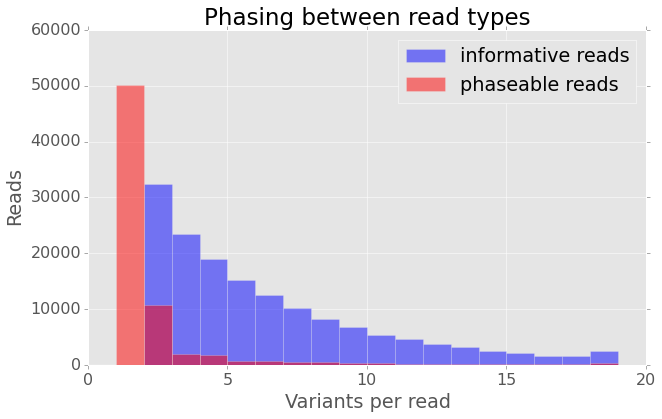

In [216]:
unphased_read_vc = [len(read.alleles) for read in unphased_reads.values()]
inform_read_vc = [len(read.alleles) for read in hair_reader.reads.values()]
pd.DataFrame(zip(unphased_read_vc, inform_read_vc)).to_csv('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv1_mq1/unphased_vs_inform_varcount.tsv', sep='\t')
plt.hist(inform_read_vc, bins=range(0,20), color='b', alpha=0.5, label="informative reads")
plt.hist(unphased_read_vc, bins=range(0,20), color='r', alpha=0.5, label="phaseable reads")
plt.legend()
plt.title('Phasing between read types')
plt.xlabel('Variants per read')
plt.ylabel('Reads')
plt.savefig("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv1_mq1/varcount_per_read.png")
plt.show()

In [215]:
for k, block in block_reader.blocks.iteritems():
    block.read_set = set(block.read_set)
for k, read in unphased_reads.iteritems():
    read.assemble_blocks(block_reader)
    if read.blockcount > 1:
        if read.end-read.start > 60000:
            continue
        for rb in read.blocks:
            sys.stdout.write(str(rb[0][0]) + '\t')
        sys.stdout.write('\t'.join([str(len(read.alleles)), str(read.start), str(read.end)]))
        sys.stdout.write('\n')

9918	9921	2	13349960	13363167
2010	2007	2	3021394	3035106
15765	15766	2	21552954	21567673
15765	15766	2	21552954	21567673
12333	12328	3	17178259	17196788


In [21]:
for readblock in read.blocks:
    print readblock
    print block_reader.loc(readblock[0][0])

[(9010, '0'), (9012, '0')]
<Block, offset_id: 8516>
[(9013, '0'), (9014, '0')]
<Block, offset_id: 8516>


In [14]:
b = block_reader.loc(1138)
for k,read in unphased_reads.iteritems():
    if read.blockcount > 1:
        read = greedy_partition(read, block_reader)
        print read.haplotype_fields()
        break

[('ZH', '8516,1'), ('ZB', 2), ('ZV', 4)]
